# **_Setup and Pre-process_**

In [1]:
# Importing dependencies.

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import cv2
import imghdr
import os
from matplotlib import pyplot as plt



# This avoids OOM errors by limiting the load on the GPUs.

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)



# Pre Processing the images.

image_exts = ['jpeg','jpg', 'bmp', 'png']
data_dir = 'train'

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))



# Establishing data pipeline.
batch_size = 32
img_height = 180
img_width = 180

class_names = ['Auto-rickshaw', 'Bicycle', 'Bus', 'Car', 'Motorcycle', 'Truck', 'Van']

data = tf.keras.utils.image_dataset_from_directory('train',class_names=class_names,image_size=(img_height, img_width),batch_size=batch_size)

data_iterator = data.as_numpy_iterator()



# Regularization.

data = data.map(lambda x,y: (x/255, y))



# Splitting data into training and validation set.

train_size = int(len(data)*.7)
val_size = int(len(data)*.3)+1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

# **Creating and Training the Model**

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam



# Data augmentation to avoid overfitting.

data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)



# Creating the neural network architecture.

model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [11]:
# Training the model and storing data in a variable

hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30


267/267 [==============================] - 93s 345ms/step - loss: 2.3339 - accuracy: 0.5192 - val_loss: 2.6314 - val_accuracy: 0.4319
Epoch 2/30
267/267 [==============================] - 92s 344ms/step - loss: 2.1543 - accuracy: 0.5501 - val_loss: 2.3094 - val_accuracy: 0.4870
Epoch 3/30
267/267 [==============================] - 93s 348ms/step - loss: 2.0066 - accuracy: 0.5749 - val_loss: 2.1139 - val_accuracy: 0.5285
Epoch 4/30
267/267 [==============================] - 93s 345ms/step - loss: 1.8927 - accuracy: 0.5886 - val_loss: 1.9877 - val_accuracy: 0.5482
Epoch 5/30
267/267 [==============================] - 93s 346ms/step - loss: 1.7861 - accuracy: 0.6017 - val_loss: 1.8266 - val_accuracy: 0.5714
Epoch 6/30
267/267 [==============================] - 93s 344ms/step - loss: 1.6744 - accuracy: 0.6175 - val_loss: 1.7528 - val_accuracy: 0.5823
Epoch 7/30
267/267 [==============================] - 93s 345ms/step - loss: 1.5825 - accuracy: 0.6307 - val_loss: 1.7208 - val_accuracy: 0.5

# **Plotting the performance**

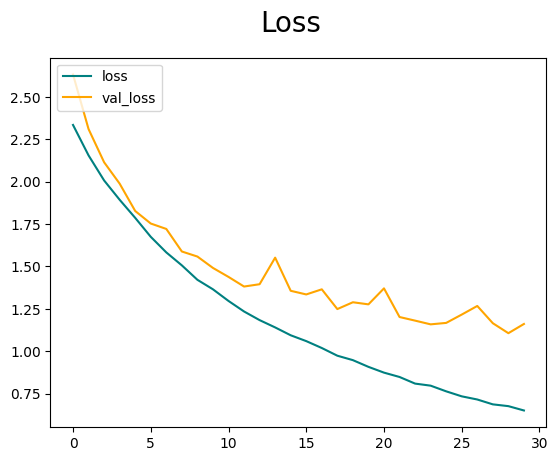

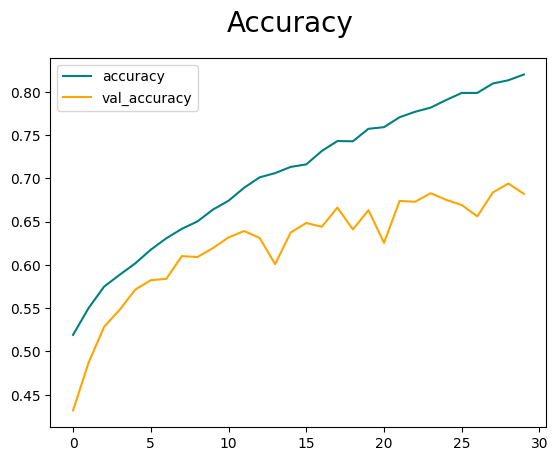

In [12]:
# Plotting the performance.

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **Saving the Model**

In [28]:
from tensorflow.keras.models import load_model

model.save(os.path.join('models','vehicleclassifier.h5'))
